In [1]:
using PyCall
using Distances
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf

In [7]:
py"""
import numpy as np
import cv2

class RootSIFT:
    def __init__(self):
        self.extractor = cv2.xfeatures2d.SIFT_create()

    def compute(self, image, kps, eps=1e-7):
        (kps, descs) = self.extractor.compute(image, kps)
        if len(kps) == 0:
            return ([], None)

        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        return (kps, descs)
def rootSIFT(img_path, resize = False):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if resize:
        scale_percent = 10  # percent of original size
        width = int(gray.shape[1] * scale_percent / 100)
        height = int(gray.shape[0] * scale_percent / 100)
        dim = (width, height)
        gray = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)

    sift = cv2.xfeatures2d.SIFT_create()
    (kps, descs) = sift.detectAndCompute(gray, None)
    rs = RootSIFT()
    (kps, descs) = rs.compute(gray, kps)
    pos = [np.array([x.pt[0], x.pt[1]]) for x in kps]

    return np.array(pos)

"""

img1_path = "../data/test/001_L.png"
img2_path = "../data/test/001_R.png"

descs1 = py"rootSIFT"(img1_path, true);
descs2 = py"rootSIFT"(img2_path, true);

In [8]:
function cleaning(original)
    res_dict = Dict()
    for i in 1:size(original, 1)
        res_dict[hash(original[i,:])] = original[i,:]
    end
    
    vals = collect(values(res_dict))
    output = zeros(size(vals,1), 2)
    for i in 1:size(vals,1)
        output[i,:] = [vals[i][1],vals[i][2]]
    end
    
    return output
end

cleaning (generic function with 1 method)

In [9]:
P_points = cleaning(descs1);
Q_points = cleaning(descs2);

In [10]:
cost = pairwise(Euclidean(), P_points, Q_points; dims=1)

103×92 Array{Float64,2}:
 61.8342   6.97698  39.1066  63.3773  82.5132   …   22.1227  41.508   32.9549
 54.0311  50.1514   20.9806  53.6356  58.2447       63.2323  40.03    16.0306
 54.8308  18.7395   30.8155  55.9986  72.8421       33.3938  34.4921  23.301 
 10.8434  75.3053   75.8165   8.2697  18.8603       91.3617  29.1754  67.9698
 42.9447  25.5713   38.3875  44.2389  62.7101       41.6521  22.527   29.763 
 28.5887  73.7006   60.5858  26.3871  18.5817   …   89.6398  33.3093  54.2305
 29.0729  77.7393   64.8922  26.6426  14.4762       93.7311  36.2779  58.6148
 14.2001  76.6323   74.6425  11.4834  15.0149       92.7606  30.7008  67.0422
 49.9954  55.0079   27.8581  49.3061  51.781        68.8091  38.2434  23.0292
 36.4867  82.4448   65.548   34.0352  17.4309       98.2434  42.8244  60.0511
 53.7622  12.6033   42.0721  55.4117  75.574    …   28.7653  33.6077  34.6739
 48.5671  93.8791   72.4837  45.9993  24.2204      109.43    55.5878  68.1352
 29.4863  86.5801   76.4332  26.7589   

In [11]:
P = ones(size(P_points,1));
Q = ones(size(Q_points,1));

In [22]:
solCount = 20
# m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0,PoolGap = 0.001))
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P), sum(Q)))
@constraint(m, X * ones(Int, length(Q)) .<= P)
@constraint(m, X'ones(Int, length(P)) .<= Q);
optimize!(m)
solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        if(round(xn_val,digits=10) != round(obj, digits=10))
            println(xn_val,' ', obj)
            break
        end
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
if(cnt == 0)
    sol_pool = deepcopy(solution_pool[1,:,:]);
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 196 rows, 9476 columns and 28428 nonzeros
Variable types: 0 continuous, 9476 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+01]
Presolve time: 0.03s
Presolved: 196 rows, 9476 columns, 28428 nonzeros
Variable types: 0 continuous, 9476 integer (9476 binary)

Root relaxation: objective 5.170151e+02, 298 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     517.0151197  517.01512  0.00%     -    0s
Optimal solution found at node 0 - now completing solution pool...
     0     0          -    0       517.01512  517.01512  0.00%     -    0s
     0     0          -    0       517.01512  517.01512  0.00%     -    0s
     0     2          -    0       517.01512  517.01512  0.00%     -    0s
 125

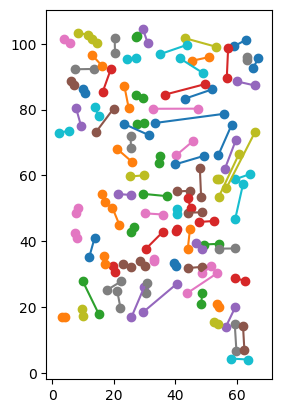

In [25]:
solOther = sparse(value.(X))
for (x,y,v) in zip(findnz(solOther)...)
    x_pos = [P_points'[:,x][1], Q_points'[:,y][1]]
    y_pos = [P_points'[:,x][2], Q_points'[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
    
end